## Baseline
This notebook implments a baseline model, which shows you how to handle the data and to provide a first very simple solution to the problem. You may re-use and modify any part of this notebook.

In [1]:
!pip install --upgrade --force-reinstall numpy pandas
!pip install transformers --quiet --upgrade
!pip install lime shap captum bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 125.2 MB/s eta 0:00:00
^C
^C


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys

# For example, let's say your package is in "/content/my_package"
package_path = "drive/MyDrive/Project_XAI_Toxicity"
if package_path not in sys.path:
    sys.path.append(package_path)

# Now you can import your package

In [3]:
!pip install lime
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import Counter
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
torch.manual_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7a192a3149ce4b77ea708eaafef7ff0c1d2042eaafd398046223b29750014404
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
data_dir = 'drive/MyDrive/Project_XAI_Toxicity/kaggle_data'

We first start by defining the dataset class which takes as input the path to the data and the mode (`train`, `val`, or `train`). This fits a count vectorizer using the training set, and uses it on the validation and test sets.

In [5]:
class BaselineDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None, frac_sample = 1.0):
        super(BaselineDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        self.mode = mode

        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)
        self.data = self.data.fillna('')
        self.data = self.data.sample(frac=frac_sample, random_state = 0)


        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode == 'train':
            self.vectorizer = CountVectorizer()
            self.vectorizer.fit(self.data.values.flatten().tolist())
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx, 0]
        x = self.vectorizer.transform([x]).toarray()
        x = torch.tensor(x).float()
        if self.mode == 'test':
            return x, idx
        else:
            y = torch.tensor([self.label.iloc[idx, -2]])
            return x, y, idx

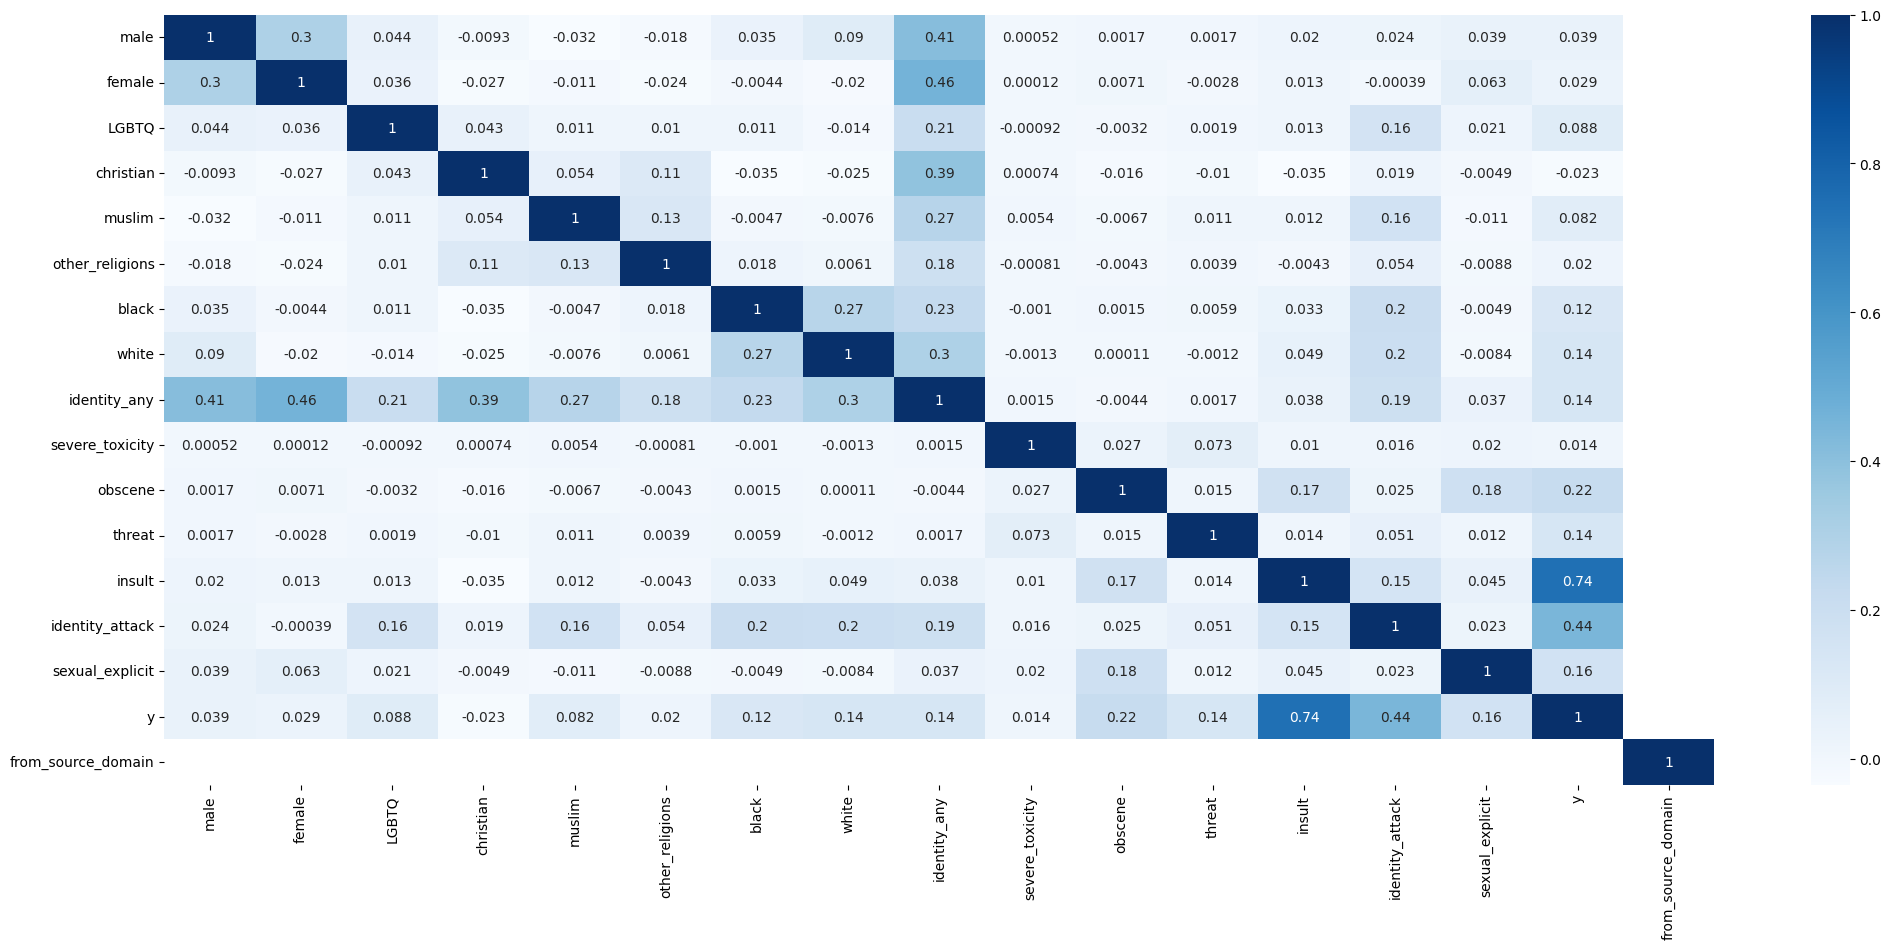

<Figure size 640x480 with 0 Axes>

In [6]:
train_dataset = BaselineDataset(data_dir, 'train')
val_dataset = BaselineDataset(data_dir, 'val', train_dataset.vectorizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

plt.figure(figsize = (25,10))
corr = train_dataset.label.corr('kendall')
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()
plt.savefig('/content/drive/MyDrive/heatmap_toxicity.png')

We will define two models, one which will be a simple MLP, and another one which will generate random predictions to use as comparison.

Let's check the performance of the random classifier on the validation set.

In [7]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga

In [8]:
class TextDataset(Dataset):
    def __init__(self, texts,tokenizer, labels = None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # extra_features: a list of lists or a 2D NumPy array
        # shape [num_samples, num_extra_feats]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx] if self.labels is not None else 0  # Or any default value

        encoded = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float),
            'idx': idx
        }

In [9]:
class newTransformer(nn.Module):
    def __init__(self,
                 model_name="google/mobilebert-uncased",
                 dropout_prob=0.1):

        super().__init__()
        #self.transformer = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.bert = self.transformer

        hidden_size = self.transformer.config.hidden_size  # e.g. 768 for DistilBERT base
        self.classifier = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, input_ids, attention_mask, labels=None):


        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask,
                                   output_attentions = True )

        hidden_state = outputs.last_hidden_state
        pooled_token = hidden_state[:, 0]


        combined = pooled_token

        combined = self.dropout(combined)
        logits = self.classifier(combined)
        #logits = outputs.logits

        loss = None
        if labels is not None:

            logits_flat = logits.view(-1)
            labels_flat = labels.view(-1)
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits_flat, labels_flat)

        return logits, outputs.attentions, loss, logits


        # return {
        #     'loss': loss,
        #     'logits': logits}

In [10]:
def train_one_epoch_transformer(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_indices = []

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        idx = batch["idx"]


        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs[2]
        logits = outputs[3]
        # loss = outputs["loss"]
        # logits = outputs["logits"]


        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size


        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().squeeze(1)
        all_preds.extend(preds.cpu().tolist()) # Add predictions to the list

        all_indices.extend(idx.tolist())

    avg_loss = total_loss / total_samples

     # Create the DataFrame for WGA
    pred_df = pd.DataFrame({
        "index": all_indices,
        "pred": all_preds
    })

    return avg_loss, pred_df  # Return both loss and prediction DataFrame

In [11]:
def evaluate_model_transformer(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_indices = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            idx = batch['idx']

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs[2]
            logits = outputs[3]

            #loss = outputs["loss"]
            #logits = outputs["logits"]

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # Convert logits => predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(1)
            all_preds.extend(preds.cpu().tolist())
            all_indices.extend(idx.tolist())


    pred_df = pd.DataFrame({"index": all_indices, "pred": all_preds}) # Create prediction DataFrame
    avg_loss = total_loss / total_samples
    return avg_loss, pred_df

In [12]:
def train_model_transformer(
    model, train_loader, val_loader, device, optimizer,num_epochs=5, train_df=None, val_df=None
):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_pred_df = train_one_epoch_transformer(model, train_loader, optimizer, device)
        # compute train WGA
        train_wga = worst_group_accuracy(train_pred_df, train_df)

        val_loss, val_pred_df = evaluate_model_transformer(model, val_loader, device)
        val_wga = worst_group_accuracy(val_pred_df, val_df)

        print(f"Train Loss: {train_loss:.4f}, Train WGA: {train_wga:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   WGA: {val_wga:.4f}")
    return train_loss,train_wga

In [28]:
val_labels[41949]

0

In [13]:
train_dataset = BaselineDataset(data_dir, 'train', frac_sample = 0.25)
val_dataset = BaselineDataset(data_dir, 'val', train_dataset.vectorizer)

train_texts = train_dataset.data.values.flatten().tolist()
train_labels = train_dataset.label.iloc[:, -2].tolist()



val_texts = val_dataset.data.values.flatten().tolist()
val_labels = val_dataset.label.iloc[:, -2].tolist()



tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
train_dataset_transformer = TextDataset(train_texts, tokenizer, labels = train_labels)
val_dataset_transformer = TextDataset(val_texts, tokenizer,labels = val_labels)

train_loader_transformer = DataLoader(train_dataset_transformer, batch_size=32, shuffle=True)
val_loader_transformer = DataLoader(val_dataset_transformer, batch_size=32, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
import time
a = time.time()

model_transformer = newTransformer()
model_transformer.to(device)

optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=1e-5)
train_loss, train_metric = train_model_transformer(model_transformer, train_loader_transformer,
                                       val_loader_transformer, device,num_epochs = 3,
                                      optimizer = optimizer_transformer,
                                      train_df = train_dataset.label,
                                      val_df = val_dataset.label)

transformer_val_loss, transformer_val_pred_df = evaluate_model_transformer(model_transformer,
                                                                           val_loader_transformer, device)
transformer_val_wga = worst_group_accuracy(transformer_val_pred_df, val_dataset.label)
print(f'Transformer classifier validation loss {transformer_val_loss:.4f} WGA {transformer_val_wga:.4f}')
b = time.time()
print(b-a)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]


Epoch 1/3


model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Train Loss: 156392.5700, Train WGA: 0.7469
Val   Loss: 9.3331, Val   WGA: 0.6562

Epoch 2/3
Train Loss: 5.0853, Train WGA: 0.6887
Val   Loss: 2.7894, Val   WGA: 0.6707

Epoch 3/3
Train Loss: 2.4342, Train WGA: 0.6876
Val   Loss: 1.0978, Val   WGA: 0.6719
Transformer classifier validation loss 1.0978 WGA 0.6719
1375.7252759933472


In [15]:
def predict_proba(texts):
    # Tokenize batch of texts
    encoded = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Make sure to switch model to eval mode
    model_transformer.eval()
    with torch.no_grad():
        outputs = model_transformer(input_ids=input_ids, attention_mask=attention_mask)
        #logits = outputs["logits"]
        logits = outputs[3]
        # Convert to probabilities with sigmoid
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        # Since it is binary, return probabilities for [non-toxic, toxic]
        probs = np.stack([1 - probs, probs], axis=1)
    return probs


In [35]:
val_labels[44578]

1

In [37]:
transformer_val_pred_df['labels'] = val_labels
transformer_val_pred_df['text'] = val_texts

In [47]:
transformer_val_pred_df[(transformer_val_pred_df['labels'] == transformer_val_pred_df['pred']) & (transformer_val_pred_df['labels'] == 0)]

index  pred  labels                                               text
5          5     0       0  often disagree with her, but Wente is exactly ...
6          6     0       0  If you tax my income to pay your PFD, the the ...
7          7     0       0  Man Democtrats don't have a clue....You use yo...
10        10     0       0  Thank you, John.  This man is despicable.  Let...
15        15     0       0  "Some argued the complaints about McConnell's ...
...      ...   ...     ...                                                ...
45175  45175     0       0  You do realize that ALL CAPS is a sure sign of...
45176  45176     0       0  The bus should be free.\nTaxpayers already sub...
45177  45177     0       0  Wow. False Flag. I never thought of that. Mayb...
45178  45178     0       0  I agree Jim, I did the same years ago as well....
45179  45179     0       0  You are sick.  Please see a mental health prof...

[39720 rows x 4 columns]

In [48]:
len(transformer_val_pred_df[transformer_val_pred_df['labels'] == 0])

40125

In [16]:
example_df = transformer_val_pred_df[-5000:]
example_df['text'] = val_texts[-5000:]
example_df['labels'] = val_labels[-5000:]
example_df['toxic_score'] = list(map(lambda x: float(predict_proba(x)[0][1]), example_df['text']))
example_df = example_df.sort_values(by='toxic_score', ascending=False)
print(example_df.head(10))
print(example_df.tail(10))

<ipython-input-16-d304fd01c978>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['text'] = val_texts[-5000:]


       index  pred                                               text  \
40968  40968     1  St Ambrose was a Roman provincial governor -- ...   
44624  44624     1  "...no Indigenous language is an official lang...   
42752  42752     1  I've never seen a man with so many bullet hole...   
40351  40351     1  Weilechowski is a "made man" for the AFL-CIO; ...   
44706  44706     1                              more restrictions lol   
40748  40748     1                                   1%'er ecoterror.   
44371  44371     1               Shall I call the wambulance for you?   
42761  42761     1                              More defiance please.   
42135  42135     1       "Donald, I thought we'd play some solitaire"   
40308  40308     1              Thank you, God's own Kellyanne Conway   

       toxic_score  
40968     1.000000  
44624     1.000000  
42752     0.995657  
40351     0.966195  
44706     0.799980  
40748     0.754845  
44371     0.641295  
42761     0.618130  
42135  

<ipython-input-16-d304fd01c978>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['toxic_score'] = list(map(lambda x: float(predict_proba(x)[0][1]), example_df['text']))


In [50]:
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])

# Explain  single instance:
idx = 40308  # index of a tweet from your validation set, for example
text_to_explain = val_texts[idx]
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=15)

# Display the explanation locally
exp.show_in_notebook(text=True)

In [53]:
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])

# Explain  single instance:
idx = 40591  # index of a tweet from your validation set, for example
text_to_explain = val_texts[idx]
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)

# Display the explanation locally
exp.show_in_notebook(text=True)

In [54]:
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])

# Explain  single instance:
idx = 833  # index of a tweet from your validation set, for example
text_to_explain = val_texts[idx]
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)

# Display the explanation locally
exp.show_in_notebook(text=True)

In [57]:
import re


def filter_token(token):
    # Remove if token is a single letter (and not a number or special token) or if it's an apostrophe.
    # Adjust your conditions as needed.
    if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        # Option: keep special tokens, or decide to filter them out.
        return True  # or False if you want to filter them
    if token == "'" or token == "’" or token == '!' or token == ':' or token == ',' or token == ', ' or token == '_' or token == '.':
        return False
    if len(token) == 1:
        return False
    if '#' in token:
        return False
    return True

def remove_digits_from_token(token):
    # Replace any digits in the token with an empty string.
    return re.sub(r'\d+', '', token)

Global vocabulary size: 147


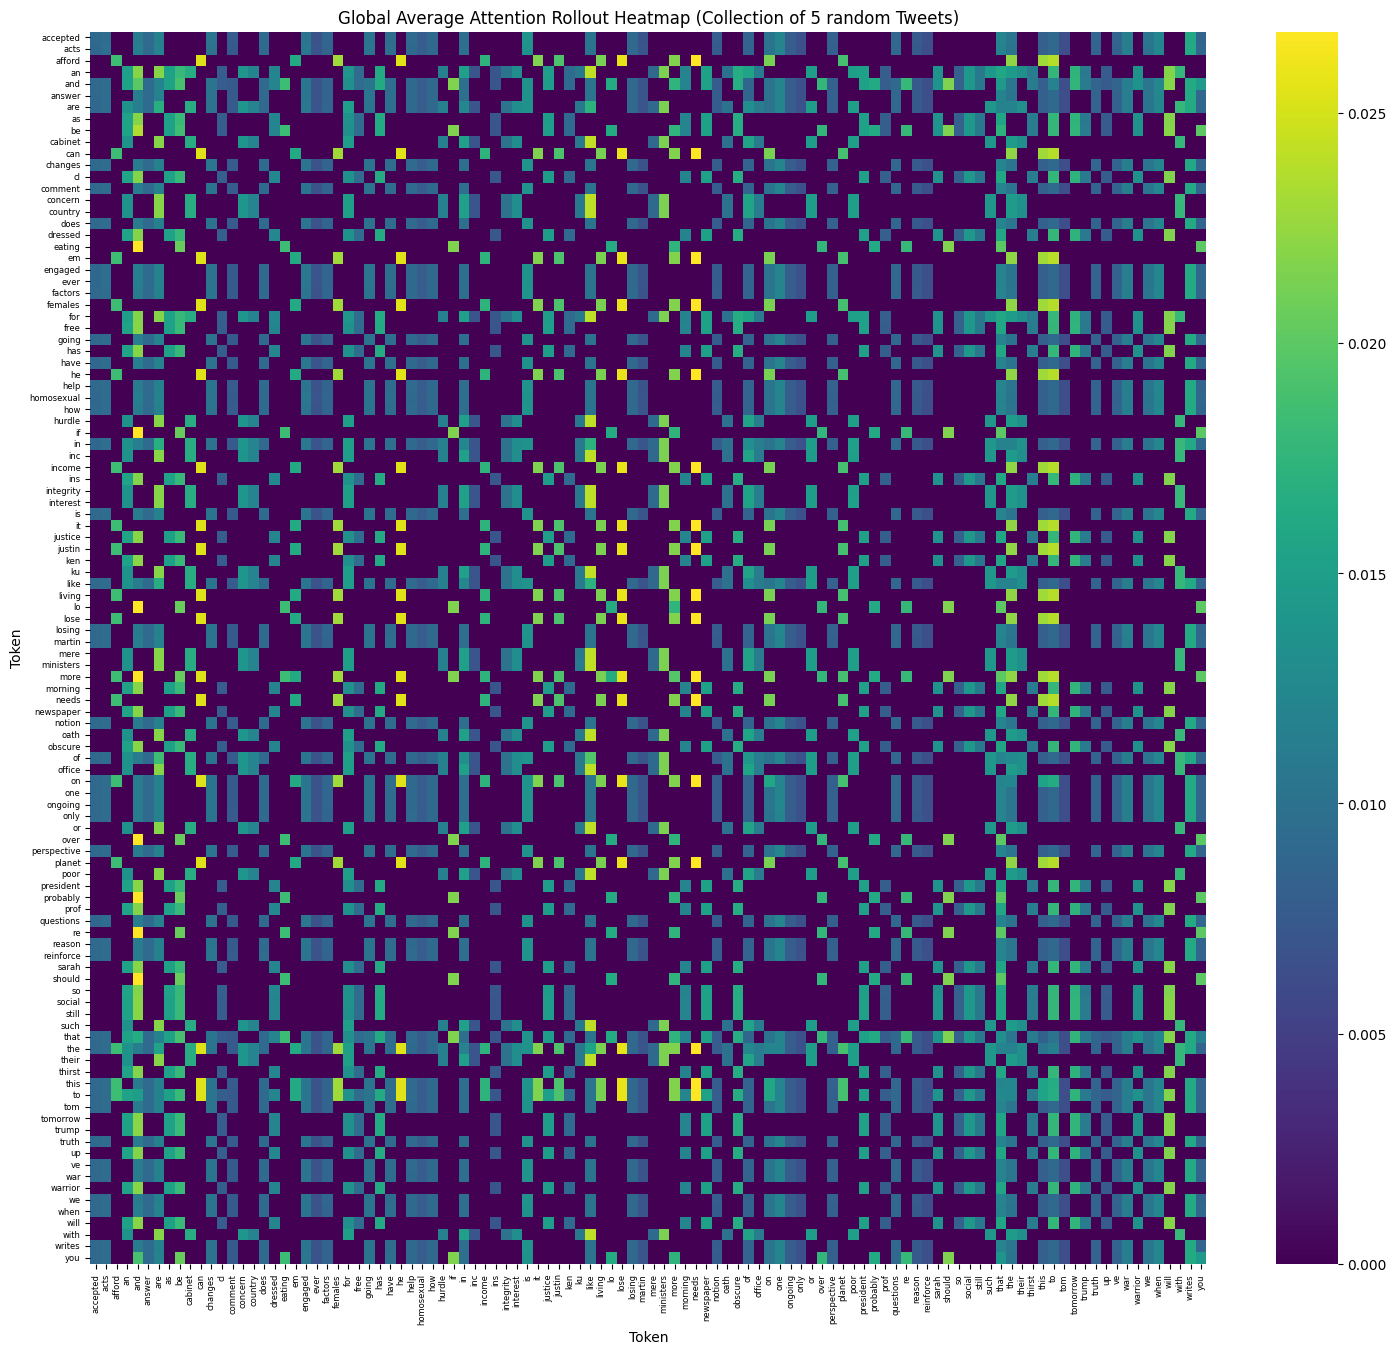

In [58]:
from Transformer_Explainability.BERT_explainability.modules.BERT.ExplanationGenerator import Generator, compute_rollout_attention
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
explainer = Generator(model_transformer)

# 1. Build a global vocabulary from the first 5 validation tweets.
global_vocab = set()
list_texts = example_df.sample(frac = 1.0, random_state = 42)['text'].tolist()[0:5]
for text in list_texts:
    # Tokenize each tweet (here using tokenizer.tokenize which returns a list of string tokens)
    tokens = tokenizer.tokenize(text)
    global_vocab.update(tokens)
global_vocab = sorted(list(global_vocab))
global_vocab = [remove_digits_from_token(token) for token in  global_vocab]
global_vocab = [token for token in global_vocab if not token.isdigit() and token.strip()!= '']

print(f"Global vocabulary size: {len(global_vocab)}")

# Create a mapping: token -> index in the global vocabulary.
vocab_to_index = {token: idx for idx, token in enumerate(global_vocab)}
vocab_size = len(global_vocab)

# 2. Initialize global aggregation matrices
global_matrix = np.zeros((vocab_size, vocab_size))
count_matrix  = np.zeros((vocab_size, vocab_size))

# 3. Process each tweet to compute its rollout and map into global space.
for text in list_texts:
    encoded = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    input_ids = encoded["input_ids"].to(device)    # device should be defined ('cuda' or 'cpu')
    attention_mask = encoded["attention_mask"].to(device)

    # Compute the full rollout matrix for this sample.
    # Make sure your Generator.generate_rollout now returns the full rollout (shape: (batch, seq_len, seq_len))
    rollout_full = explainer.generate_rollout(input_ids, attention_mask, start_layer=0)
    # Use the first (and only) sample in the batch:
    rollout_local = rollout_full[0].detach().cpu().numpy()  # shape: (max_length, max_length)

    # Get the token list corresponding to this tweet.
    tokens_local = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Map the local rollout matrix into the global vocabulary.
    for i, token_i in enumerate(tokens_local):
        for j, token_j in enumerate(tokens_local):
            # Only map tokens that are in our global vocabulary.
            if token_i in vocab_to_index and token_j in vocab_to_index:
                idx_i = vocab_to_index[token_i]
                idx_j = vocab_to_index[token_j]
                global_matrix[idx_i, idx_j] += rollout_local[i, j]
                count_matrix[idx_i, idx_j]  += 1

# 4. Compute the average global rollout matrix.
# Avoid division by zero: only divide where count_matrix > 0.
avg_global_matrix = np.zeros_like(global_matrix)
nonzero = count_matrix > 0
avg_global_matrix[nonzero] = global_matrix[nonzero] / count_matrix[nonzero]

# Optionally, you might want to remove special tokens from the visualization.
# For example, if you wish to exclude [CLS], [SEP], [PAD]:
special_tokens = {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}
filtered_indices = [i for i, token in enumerate(global_vocab) if token not in special_tokens and filter_token(token)]
filtered_avg_matrix = avg_global_matrix[np.ix_(filtered_indices, filtered_indices)]
filtered_vocab = [global_vocab[i] for i in filtered_indices]
# 5. Plot the global heatmap.
plt.figure(figsize=(18, 16))
sns.heatmap(filtered_avg_matrix, xticklabels=filtered_vocab, yticklabels=filtered_vocab, cmap="viridis")
plt.title("Global Average Attention Rollout Heatmap (Collection of 5 random Tweets)")
plt.xlabel("Token")
plt.ylabel("Token")
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Global vocabulary size: 112


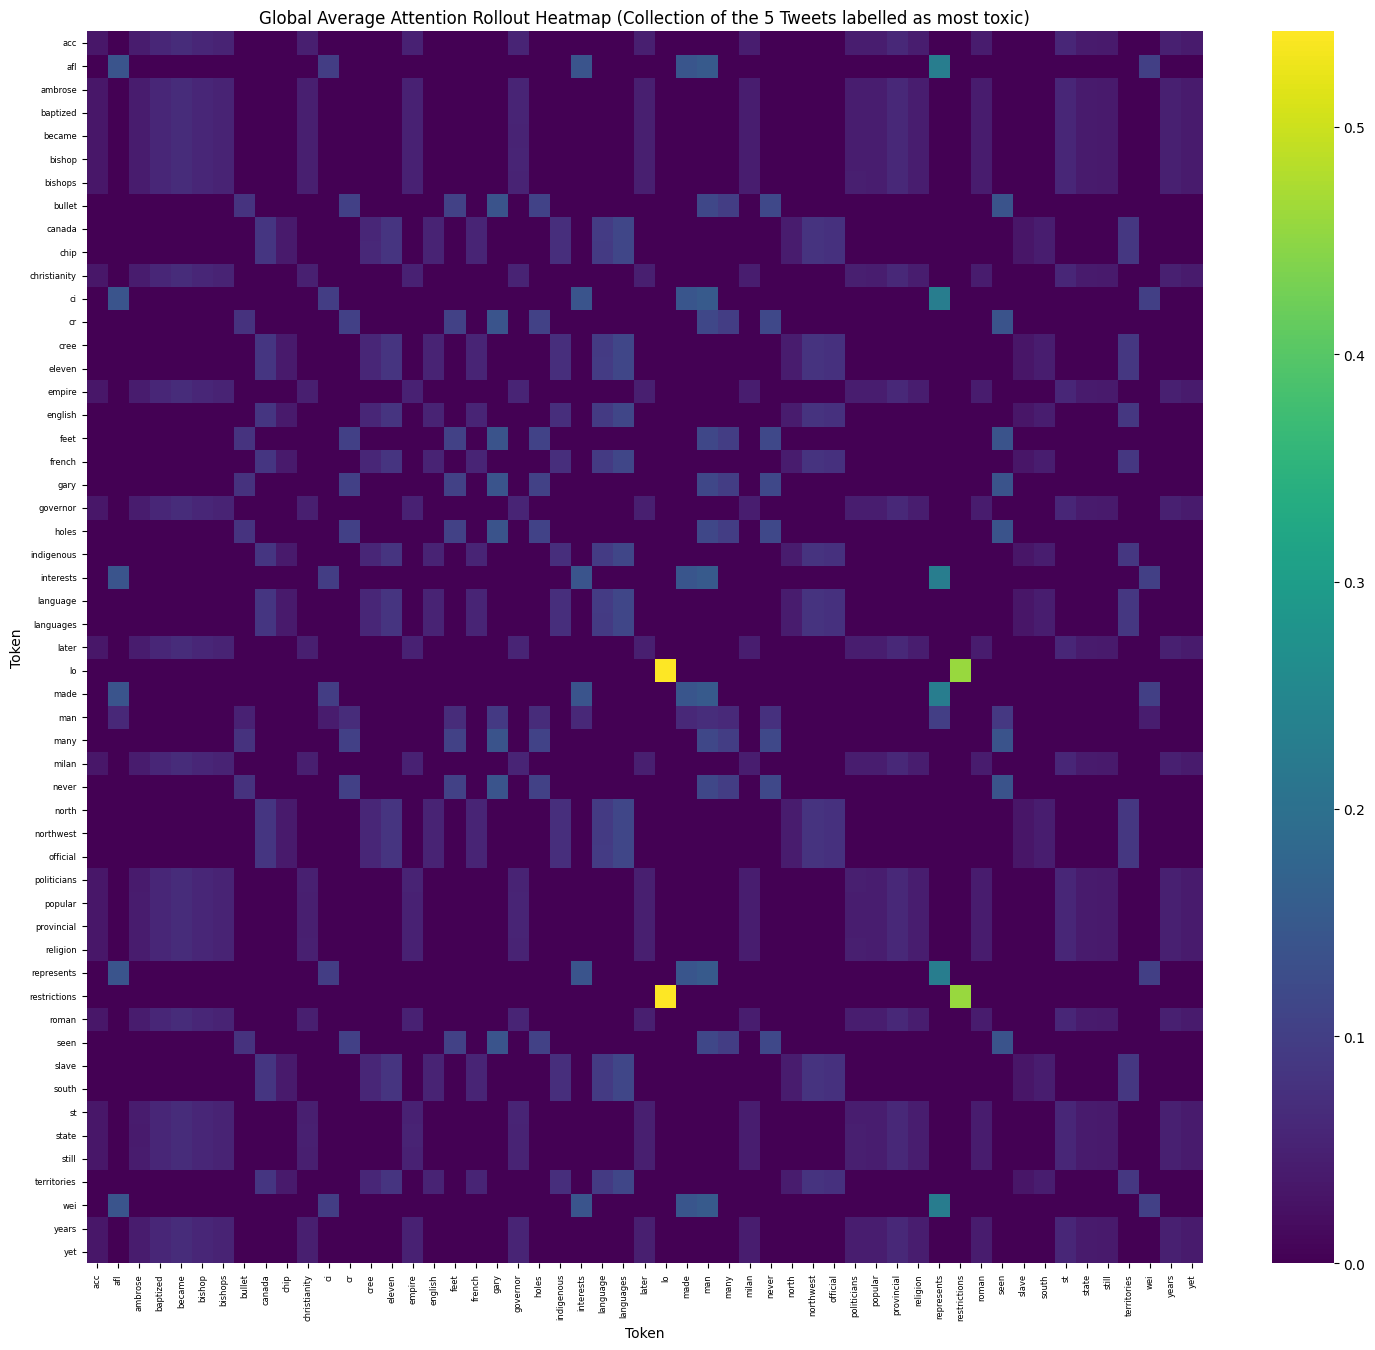

In [59]:
from Transformer_Explainability.BERT_explainability.modules.BERT.ExplanationGenerator import Generator, compute_rollout_attention
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
explainer = Generator(model_transformer)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# English pronouns, conjunctions, articles, etc.
stop_words = set(stopwords.words('english'))

# You can also extend it with model‑specific tokens:
stop_words.update(["[PAD]", "[CLS]", "[SEP]"])

# 1. Build a global vocabulary from the first 5 validation tweets.
global_vocab = set()
list_texts = example_df['text'].tolist()[0:5]
for text in list_texts:
    # Tokenize each tweet (here using tokenizer.tokenize which returns a list of string tokens)
    tokens = tokenizer.tokenize(text)
    global_vocab.update(tokens)
global_vocab = sorted(list(global_vocab))
global_vocab = [remove_digits_from_token(token) for token in  global_vocab]
global_vocab = [token for token in global_vocab if not token.isdigit() and token.strip()!= '']
print(f"Global vocabulary size: {len(global_vocab)}")

# Create a mapping: token -> index in the global vocabulary.
vocab_to_index = {token: idx for idx, token in enumerate(global_vocab)}
vocab_size = len(global_vocab)

# 2. Initialize global aggregation matrices
global_matrix = np.zeros((vocab_size, vocab_size))
count_matrix  = np.zeros((vocab_size, vocab_size))

# 3. Process each tweet to compute its rollout and map into global space.
for text in list_texts:
    encoded = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    input_ids = encoded["input_ids"].to(device)    # device should be defined ('cuda' or 'cpu')
    attention_mask = encoded["attention_mask"].to(device)

    # Compute the full rollout matrix for this sample.
    # Make sure your Generator.generate_rollout now returns the full rollout (shape: (batch, seq_len, seq_len))
    rollout_full = explainer.generate_rollout(input_ids, attention_mask, start_layer=0)
    # Use the first (and only) sample in the batch:
    rollout_local = rollout_full[0].detach().cpu().numpy()  # shape: (max_length, max_length)

    # Get the token list corresponding to this tweet.
    tokens_local = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Map the local rollout matrix into the global vocabulary.
    for i, token_i in enumerate(tokens_local):
        for j, token_j in enumerate(tokens_local):
            # Only map tokens that are in our global vocabulary.
            if token_i in vocab_to_index and token_j in vocab_to_index:
                idx_i = vocab_to_index[token_i]
                idx_j = vocab_to_index[token_j]
                global_matrix[idx_i, idx_j] += rollout_local[i, j]
                count_matrix[idx_i, idx_j]  += 1

# 4. Compute the average global rollout matrix.
# Avoid division by zero: only divide where count_matrix > 0.
avg_global_matrix = np.zeros_like(global_matrix)
nonzero = count_matrix > 0
avg_global_matrix[nonzero] = global_matrix[nonzero] / count_matrix[nonzero]

# Optionally, you might want to remove special tokens from the visualization.
# For example, if you wish to exclude [CLS], [SEP], [PAD]:
special_tokens = {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}
filtered_indices = [i for i, token in enumerate(global_vocab) if token not in special_tokens and filter_token(token) and token.lower() not in stop_words]
filtered_avg_matrix = avg_global_matrix[np.ix_(filtered_indices, filtered_indices)]
row_sums = filtered_avg_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
filtered_avg_matrix = filtered_avg_matrix / row_sums
filtered_vocab = [global_vocab[i] for i in filtered_indices]
# 5. Plot the global heatmap.
plt.figure(figsize=(18, 16))
sns.heatmap(filtered_avg_matrix, xticklabels=filtered_vocab, yticklabels=filtered_vocab, cmap="viridis")
plt.title("Global Average Attention Rollout Heatmap (Collection of the 5 Tweets labelled as most toxic)")
plt.xlabel("Token")
plt.ylabel("Token")
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()

Global vocabulary size: 8557


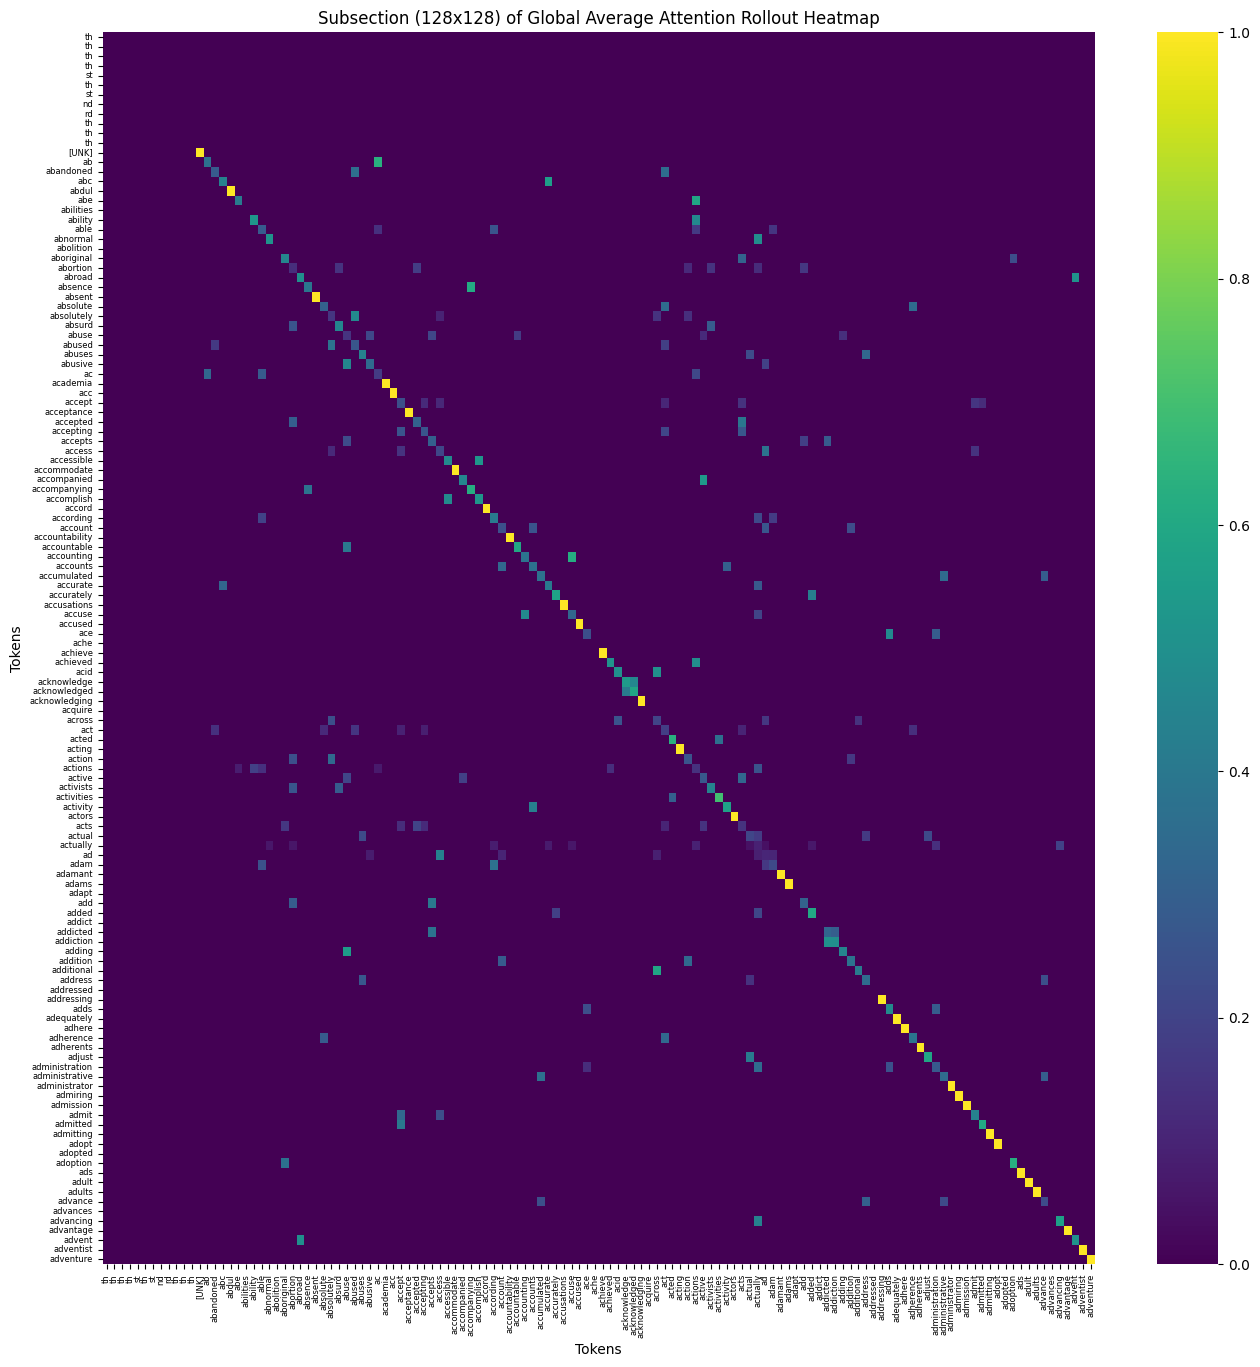

In [61]:
global_vocab = set()
list_texts = example_df.sample(frac = 1.0, random_state = 42)['text'].tolist()[0:1000]
for text in list_texts:
    # Tokenize each tweet (here using tokenizer.tokenize which returns a list of string tokens)
    tokens = tokenizer.tokenize(text)
    global_vocab.update(tokens)
global_vocab = sorted(list(global_vocab))
global_vocab = [remove_digits_from_token(token) for token in  global_vocab]
global_vocab = [token for token in global_vocab if not token.isdigit() and token.strip()!= '']
print(f"Global vocabulary size: {len(global_vocab)}")

# Create a mapping: token -> index in the global vocabulary.
vocab_to_index = {token: idx for idx, token in enumerate(global_vocab)}
vocab_size = len(global_vocab)

# 2. Initialize global aggregation matrices
global_matrix = np.zeros((vocab_size, vocab_size))
count_matrix  = np.zeros((vocab_size, vocab_size))

# 3. Process each tweet to compute its rollout and map into global space.
for text in list_texts:
    encoded = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    input_ids = encoded["input_ids"].to(device)    # device should be defined ('cuda' or 'cpu')
    attention_mask = encoded["attention_mask"].to(device)

    # Compute the full rollout matrix for this sample.
    # Make sure your Generator.generate_rollout now returns the full rollout (shape: (batch, seq_len, seq_len))
    rollout_full = explainer.generate_rollout(input_ids, attention_mask, start_layer=0)
    # Use the first (and only) sample in the batch:
    rollout_local = rollout_full[0].detach().cpu().numpy()  # shape: (max_length, max_length)

    # Get the token list corresponding to this tweet.
    tokens_local = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Map the local rollout matrix into the global vocabulary.
    for i, token_i in enumerate(tokens_local):
        for j, token_j in enumerate(tokens_local):
            # Only map tokens that are in our global vocabulary.
            if token_i in vocab_to_index and token_j in vocab_to_index:
                idx_i = vocab_to_index[token_i]
                idx_j = vocab_to_index[token_j]
                global_matrix[idx_i, idx_j] += rollout_local[i, j]
                count_matrix[idx_i, idx_j]  += 1

# 4. Compute the average global rollout matrix.
# Avoid division by zero: only divide where count_matrix > 0.
avg_global_matrix = np.zeros_like(global_matrix)
nonzero = count_matrix > 0
avg_global_matrix[nonzero] = global_matrix[nonzero] / count_matrix[nonzero]

# Optionally, you might want to remove special tokens from the visualization.
# For example, if you wish to exclude [CLS], [SEP], [PAD]:
special_tokens = {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}
filtered_indices = [i for i, token in enumerate(global_vocab) if token not in special_tokens and filter_token(token) and token.lower() not in stop_words]
filtered_avg_matrix = avg_global_matrix[np.ix_(filtered_indices, filtered_indices)]
# 5. Plot the global heatmap.
sub_matrix = filtered_avg_matrix[:128, :128]
sub_vocab = filtered_vocab[:128]

row_sums = sub_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
sub_matrix = sub_matrix / row_sums
filtered_vocab = [global_vocab[i] for i in filtered_indices]
plt.figure(figsize=(16, 16))
sns.heatmap(sub_matrix, xticklabels=sub_vocab, yticklabels=sub_vocab, cmap="viridis")
plt.title("Subsection (128x128) of Global Average Attention Rollout Heatmap")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()